In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io

In [32]:
# examples : sac_NLOS_seed_0__2024-10-22_10-57-03 , TD3_LOS__2024-08-09_00-54-12
experiment_name = 'sac__2024-07-28_20-49-12'
experiment_path = os.path.join('../experiments/runs/', experiment_name,'beamforming_gain_records')

if os.path.exists(experiment_path):
    num_files = len([f for f in os.listdir(experiment_path) if os.path.isfile(os.path.join(experiment_path, f))])
    print(f"Number of beams in the experiment: {num_files}")
else:
    num_files = 0

beams_data = []

# Load data from all numpy files
for i in range(num_files):
    filename = f'beam_{i}_gain_records.npy'
    filepath = os.path.join(experiment_path, filename)
    data = np.load(filepath)
    beams_data.append(data)


Number of beams in the experiment: 4


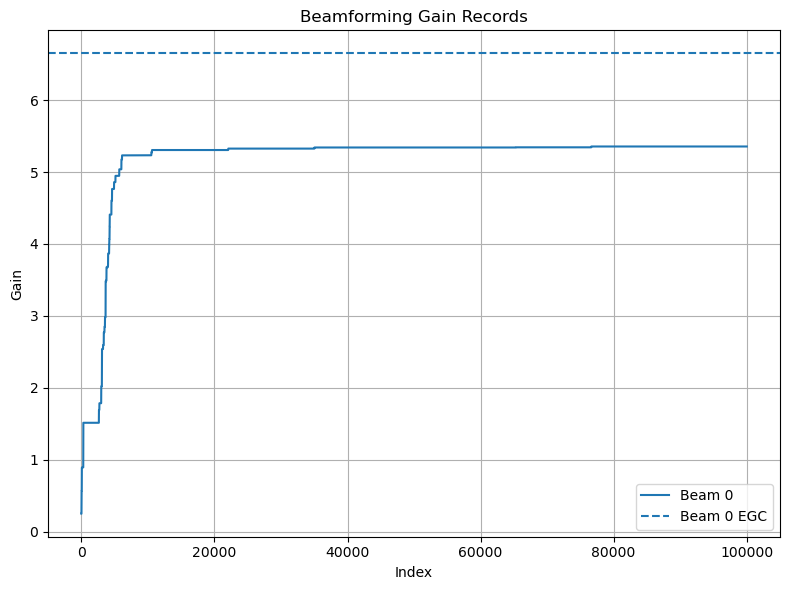

In [33]:
beam_index = 0  #beam index to plot

plt.figure(figsize=(8, 6))
plt.plot(beams_data[beam_index][:-1], label=f'Beam {beam_index}')
plt.axhline(y=beams_data[beam_index][-1], linestyle='--', 
                label=f'Beam {beam_index} EGC')

plt.xlabel('Index')
plt.ylabel('Gain')
plt.title('Beamforming Gain Records')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

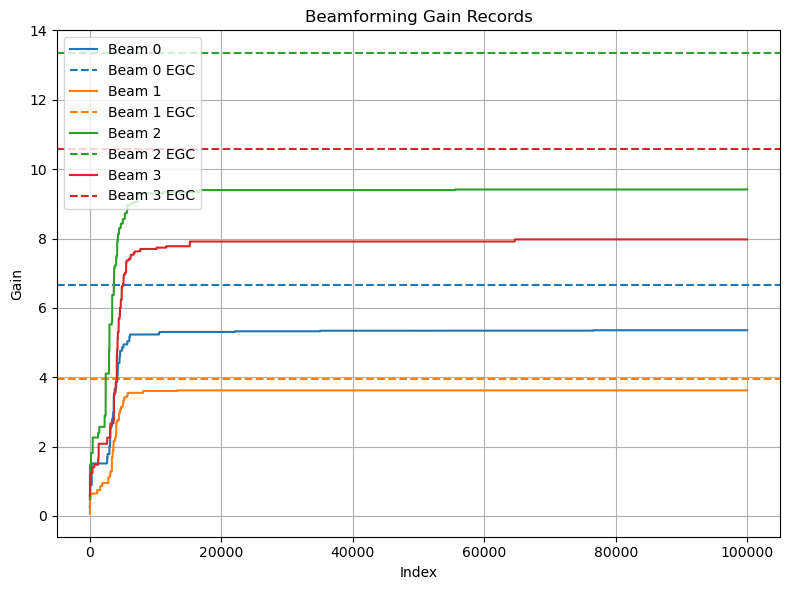

In [34]:

# Plotting
plt.figure(figsize=(8, 6))

for i, data in enumerate(beams_data):
    line, = plt.plot(data[:-1], label=f'Beam {i}')
    color = line.get_color()
    plt.axhline(y=data[-1], color=color, linestyle='--', 
                label=f'Beam {i} EGC')
plt.xlabel('Index')
plt.ylabel('Gain')
plt.title('Beamforming Gain Records')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()